### 使用sk-learn

In [4]:
from sklearn import datasets
import numpy as py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris=datasets.load_iris()
X=iris.data[:,[2,3]]
y=iris.target

In [3]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)#stratify保证了数据分层的一致性

In [8]:
print(np.bincount(y))
print(np.bincount(y_train))
print(np.bincount(y_test))

[50 50 50]
[35 35 35]
[15 15 15]


In [6]:
sc=StandardScaler()
sc.fit(X_train)#用训练集的均值和标准差来标准化测试集合训练集
X_train_sd=sc.transform(X_train)
X_test_sd=sc.transform(X_test)

### 感知器

In [19]:
ppn=Perceptron(max_iter=40,eta0=0.01,random_state=1)
ppn.fit(X_train_sd,y_train)

Perceptron(eta0=0.01, max_iter=40, random_state=1)

In [23]:
y_pred=ppn.predict(X_test_sd)
(y_pred!=y_test).sum()#预测错误的

2

In [26]:
accuracy_score(y_test,y_pred)

0.9555555555555556

In [8]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='yellow',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

<ipython-input-17-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


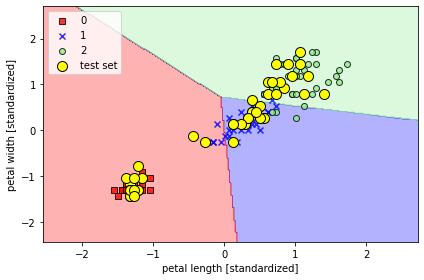

In [20]:
# Training a perceptron model using the standardized training data:

X_combined_std = np.vstack((X_train_sd, X_test_sd))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

### logit回归分类

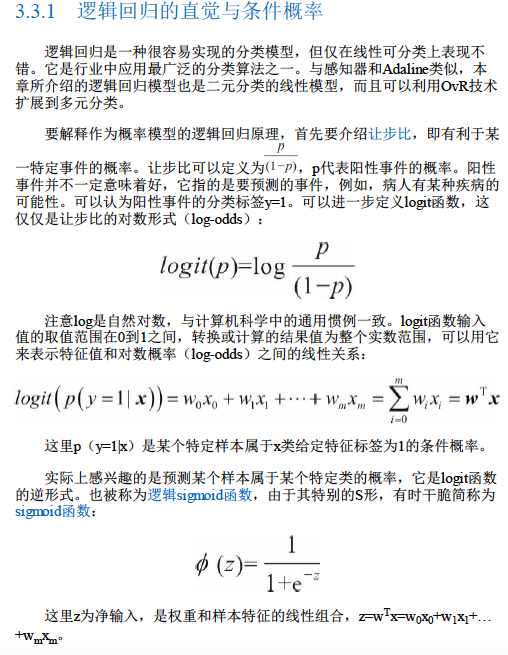

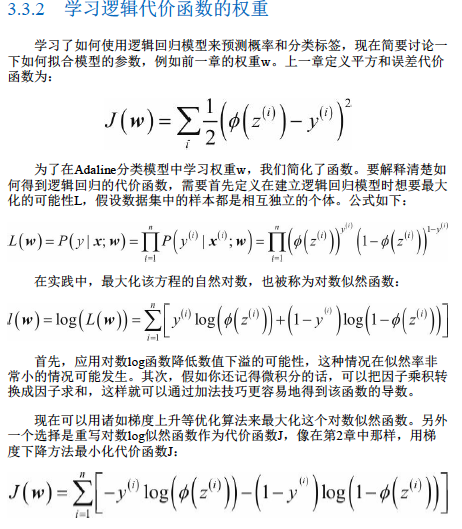

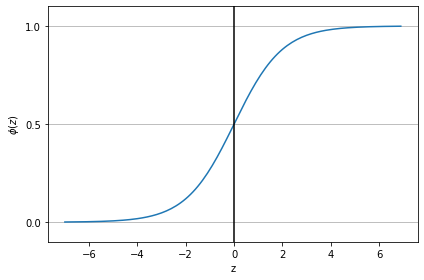

In [5]:
# sinmoid函数
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()

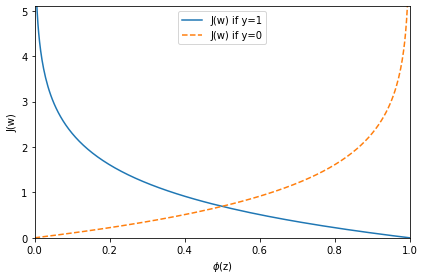

In [4]:
#成本代价的变化情况
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

In [10]:
#将自适应感知器的激活函数和成本函数换成logit回归的
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """

    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))#logit的成本函数
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))#logit的激活函数

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

<ipython-input-12-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


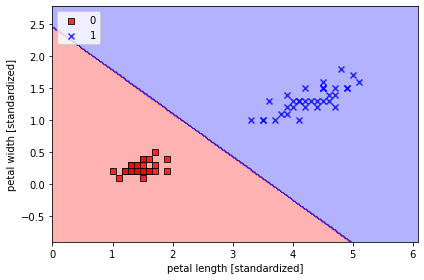

In [13]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

In [15]:
#使用sklean自带的API进行logit回归分类
lr=LogisticRegression(C=100,random_state=1)#C是控制正则化强度的，C越小正则化强度越大
lr.fit(X_train_sd,y_train)

LogisticRegression(C=100, random_state=1)

<ipython-input-17-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


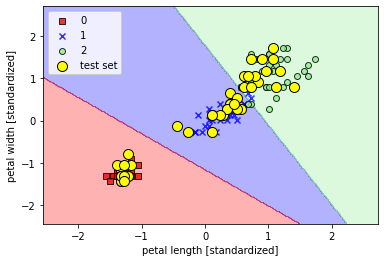

In [23]:
plot_decision_regions(X_combined_std,y_combined,classifier=lr,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

In [24]:
print(lr.predict_proba(X_test_sd[:3,:]))
print(lr.predict_log_proba(X_test_sd[:3,:]))

[[1.52213484e-12 3.85303417e-04 9.99614697e-01]
 [9.93560717e-01 6.43928295e-03 1.14112016e-15]
 [9.98655228e-01 1.34477208e-03 1.76178271e-17]]
[[-2.72109073e+01 -7.86147944e+00 -3.85377667e-04]
 [-6.46010456e-03 -5.04533809e+00 -3.44067660e+01]
 [-1.34567709e-03 -6.61153074e+00 -3.85776204e+01]]


In [25]:
print(lr.predict_proba(X_test_sd[:3,:]).sum(axis=1))#l列和为1

[1. 1. 1.]


In [30]:
print(lr.predict(X_test_sd[:3,:]))

[2 0 0]


### 正则化解决过拟合的问题

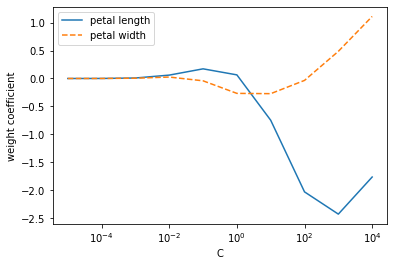

In [32]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_sd, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()#增加正则化强度，估计的参数权重就会变小

### 支持向量机

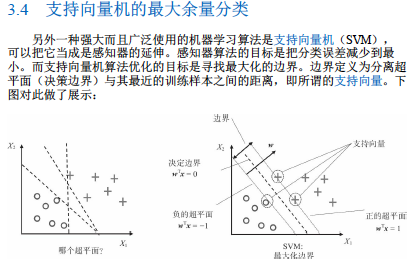
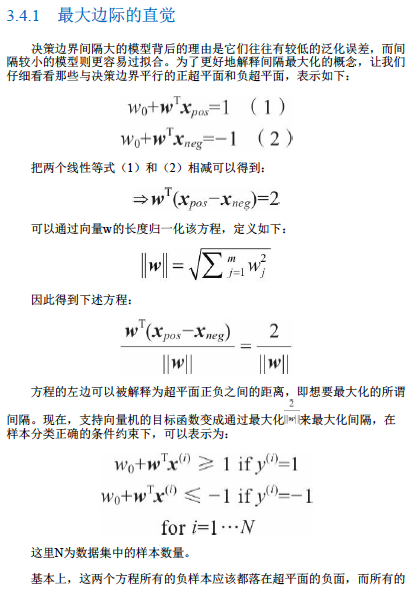
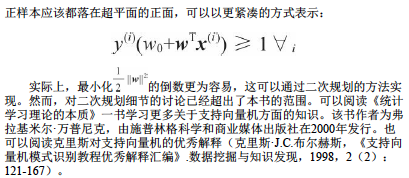

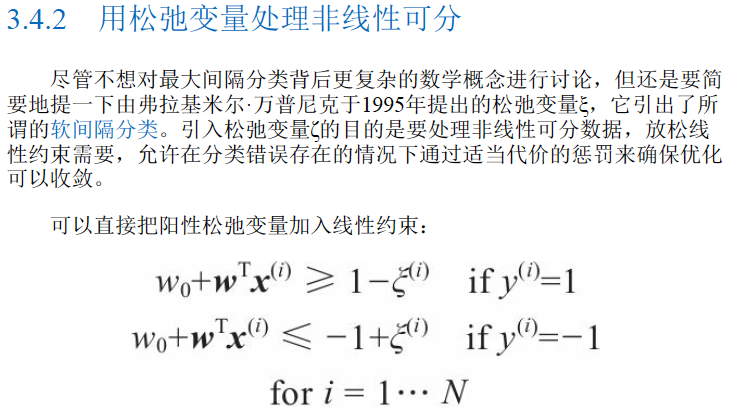
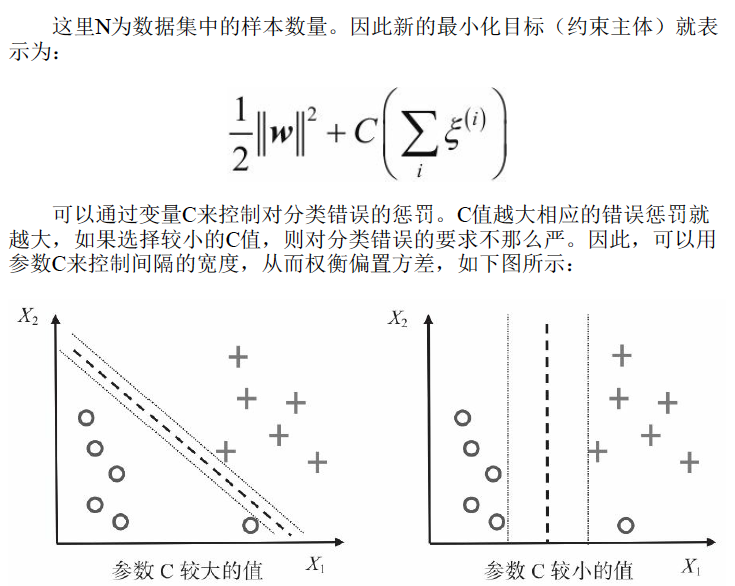

In [33]:
from sklearn.svm import SVC

<ipython-input-17-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


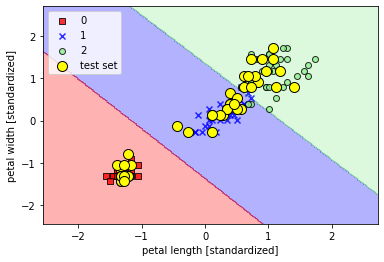

In [34]:
svm=SVC(kernel='linear',C=1,random_state=1)
svm.fit(X_train_sd,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

### 与原生Python相比，用LIBLINEAR和LIBSVM的好处是它们允许快速训练大量线性分类器。然而，有时候数据太多无法加载到内存。因此，scikit-learn也提供了通过SGDClassifier类实现的不同函数，同时通过调用partial_fit支持在线学习。SGDClassifier类的逻辑与第2章为Adaline实现的随机梯度算法类似。初始化随机梯度下降感知器、逻辑回归和带有默认参数的支持向量机如下：

In [35]:
from sklearn.linear_model import SGDClassifier

In [37]:
ppn=SGDClassifier(loss='perceptron')
lr=SGDClassifier(loss='log')
svm=SGDClassifier(loss='hinge')

### 用核支持向量机解决非线性问题

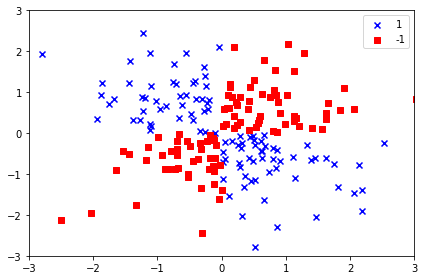

In [48]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)  # 产生2*100的服从标准正态分布的数
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)  # 相同是False，不相同是true
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_12.png', dpi=300)
plt.show()

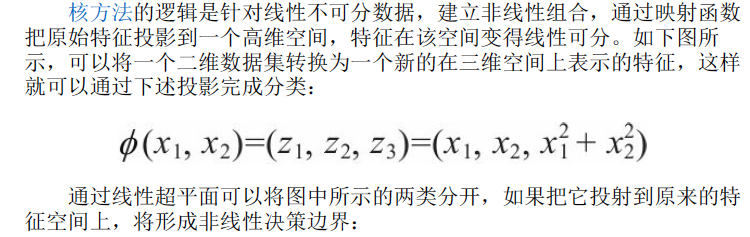
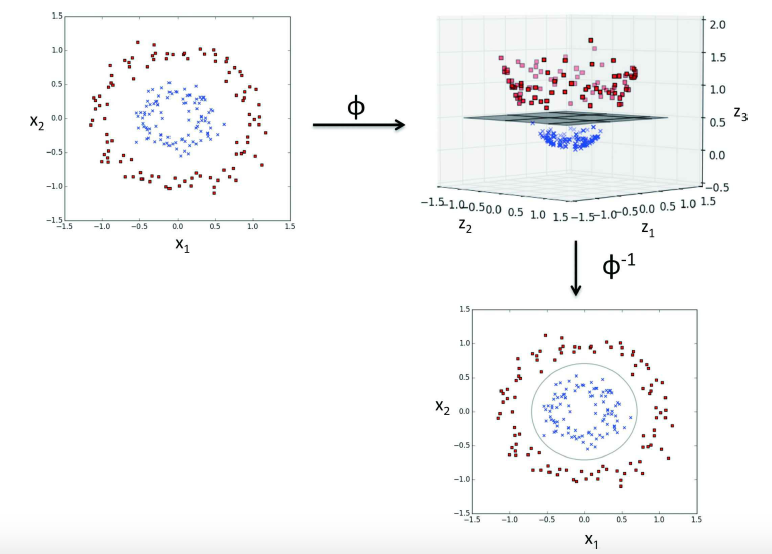

### 核函数和映射没有关系。核函数只是用来计算映射到高维空间之后的内积的一种简便方法。简而言之，术语“核”可以理解为两个样本之间的相似性函数。公式中的负号把距离反转为相似性得分值，而指数运算把由此而产生的相似性得分值控制在1（完全相似）和0（非常不同）之间。

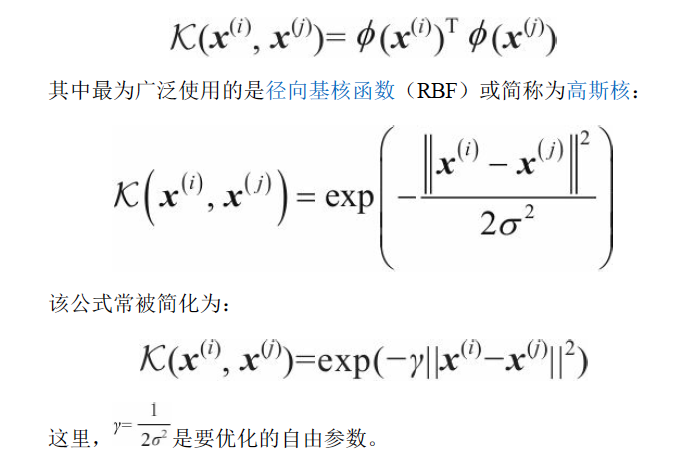

<ipython-input-17-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


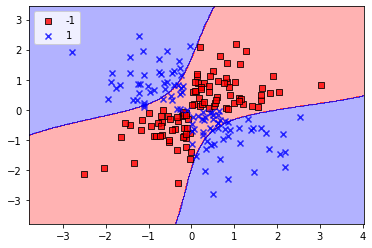

In [50]:
#非线性svm
svm=SVC(kernel='rbf',random_state=1,gamma=0.1,C=1)
svm.fit(X_xor,y_xor)
plot_decision_regions(X_xor,y_xor,classifier=svm)
plt.legend(loc='upper left')
plt.show()

### 参数γ的值设置为0.1，可以理解为高斯球的截止参数。增大γ值，将加大训练样本的影响范围，导致决策边界紧缩和波动。为了更好地理解γ，把RBF核支持向量机应用于鸢尾花数据集：

<ipython-input-17-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


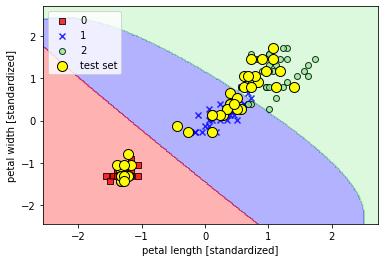

In [51]:
#非线性解决鸢尾花分类问题
svm=SVC(kernel='rbf',C=1,random_state=1,gamma=0.2)
svm.fit(X_train_sd,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

<ipython-input-17-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


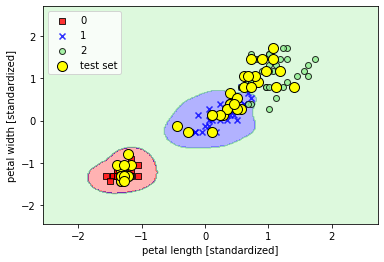

In [54]:
#非线性解决鸢尾花分类问题
svm=SVC(kernel='rbf',C=1,random_state=1,gamma=10)
svm.fit(X_train_sd,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

### 决策树分类

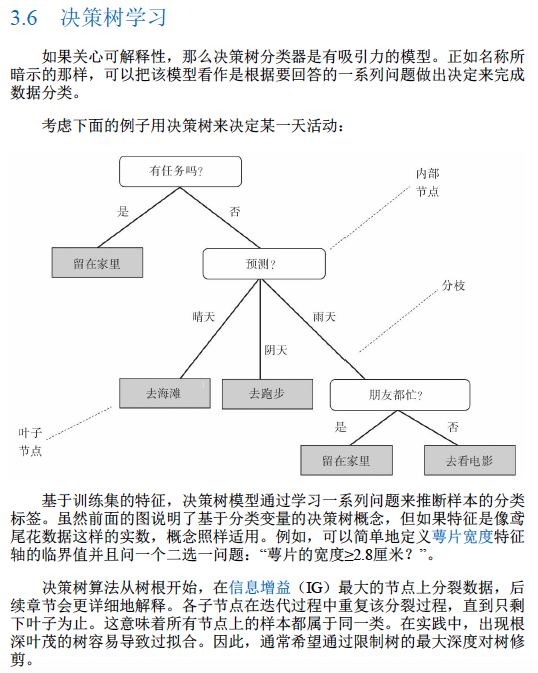

In [10]:
tree=DecisionTreeClassifier(criterion='gini',random_state=1,max_depth=4)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [13]:
y_train

array([0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2,
       1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0,
       0, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1,
       2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
       2, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0])

<ipython-input-8-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


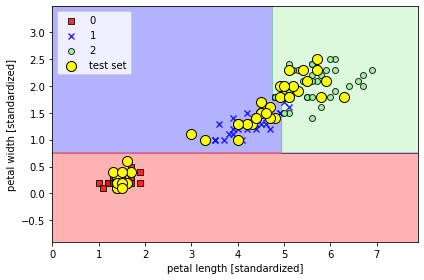

In [31]:
X_combined= np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=tree, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

In [32]:
#化决策树的图
#pip install pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
dot_data=export_graphviz(tree,filled=True,rounded=True,class_names=
                        ['Setosa','Versico','Virginica'],
                        feature_names=['petal length','petal width'],
                        out_file=None)
graph=graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

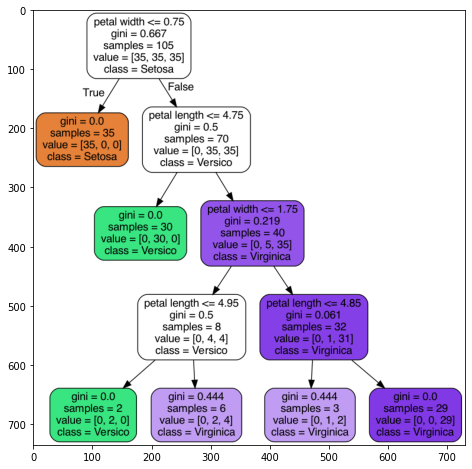

In [33]:
tree_png=plt.imread("tree.png")
plt.figure(figsize=(10,8))
plt.imshow(tree_png)

### 随机森林

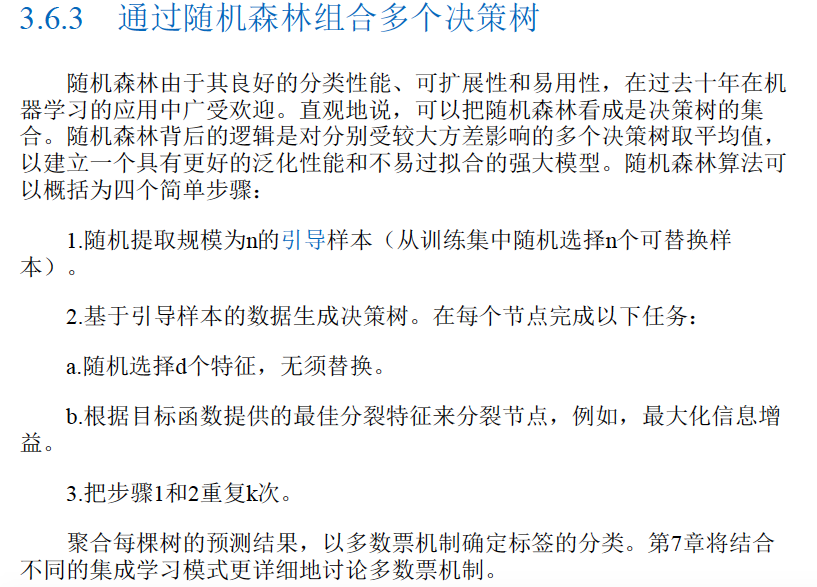

In [25]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)#n_estimators设置决策树的数量，
#n_jobs设置计算的内核数量
forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

<ipython-input-8-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


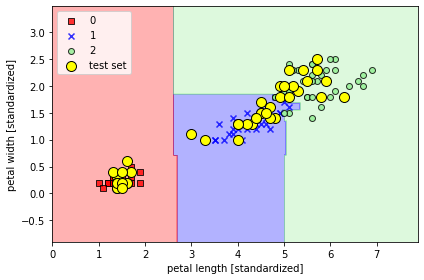

In [35]:
plot_decision_regions(X=X_combined, y=y_combined,
                      classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

### KNN分类

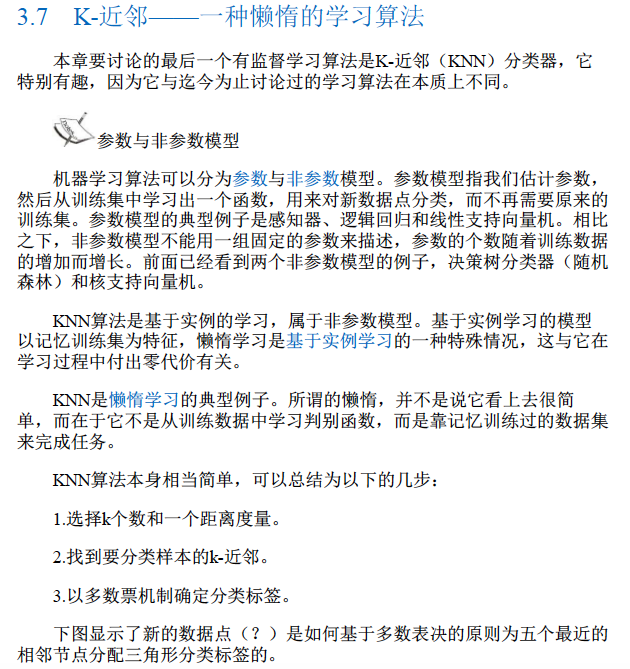
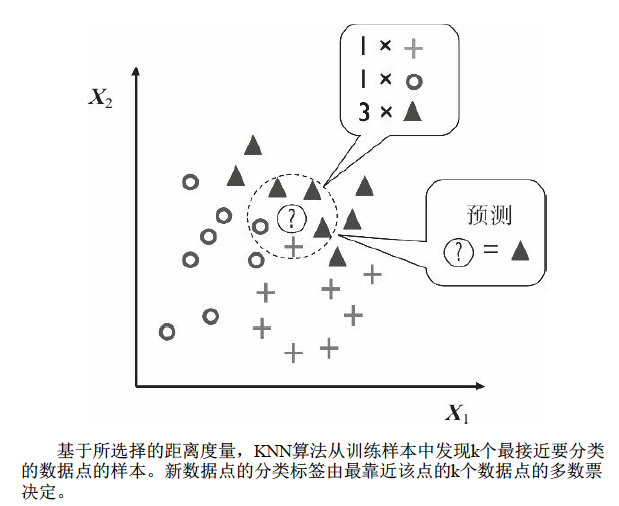

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5,p=2,metric="minkowski")

<ipython-input-8-bd5361dec362>:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


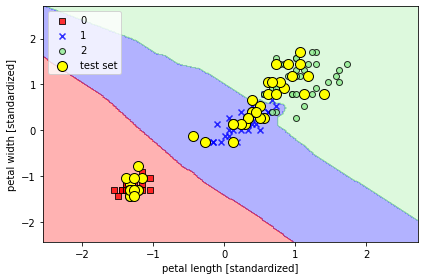

In [43]:
knn.fit(X_train_sd,y_train)
X_combined_sd= np.vstack((X_train_sd, X_test_sd))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_sd, y=y_combined,
                      classifier=knn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

### 本章学习了许多不同的解决线性和非线性问题的机器学习算法。如果关心可解释性，决策树特别有吸引力。逻辑回归不仅是一种有用的在线随机梯度下降模型，而且还可以预测特定事件的概率。虽然支持向量机有强大的线性模型，也可以通过核技巧扩展到非线性问题，但必须调整许多参数才能做好预测。相比之下，像随机森林这样的组合方法不需要调整太多参数，而且不易过拟合，像决策树一样容易，这使得其成为许多实际问题领域具有吸引力的模型。KNN分类器通过懒惰学习提供了另一种分类方法，允许在没有任何模型训练的情况下进行预测，但预测所涉及的计算成本昂贵。